<a href="https://colab.research.google.com/github/mordor-ai/M2-MIASHS-DIVERS/blob/main/Correction_TP_CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://download.wetransfer.com//eu2/c276d38b643ccb87bc1ddc93a1948dff20210106002829/28c8e85490c006cc8cf910b209292e4c4ce0c155/visages_only.tar.gz?cf=y&token=eyJhbGciOiJIUzI1NiJ9.eyJleHAiOjE2MDk5NDQxMzcsInVuaXF1ZSI6ImMyNzZkMzhiNjQzY2NiODdiYzFkZGM5M2ExOTQ4ZGZmMjAyMTAxMDYwMDI4MjkiLCJmaWxlbmFtZSI6InZpc2FnZXNfb25seS50YXIuZ3oiLCJ3YXliaWxsX3VybCI6Imh0dHA6Ly9wcm9kdWN0aW9uLmJhY2tlbmQuc2VydmljZS5ldS13ZXN0LTEud3Q6OTI5Mi93YXliaWxsL3YxL3Nhcmthci84NTdjYTA0ZWVjMDMxZDIyZTMzMDJlYmFjOGNhZDg5NTIxMDBhNjRkNjliZWM0MWE5MTZhOWU1Njk0MjU5YTcwNjA4ZTYzOWI0NGI0NjA3YTM3ZmFjZCIsImZpbmdlcnByaW50IjoiMjhjOGU4NTQ5MGMwMDZjYzhjZjkxMGIyMDkyOTJlNGM0Y2UwYzE1NSIsImNhbGxiYWNrIjoie1wiZm9ybWRhdGFcIjp7XCJhY3Rpb25cIjpcImh0dHA6Ly9wcm9kdWN0aW9uLmZyb250ZW5kLnNlcnZpY2UuZXUtd2VzdC0xLnd0OjMwMDAvd2ViaG9va3MvYmFja2VuZFwifSxcImZvcm1cIjp7XCJ0cmFuc2Zlcl9pZFwiOlwiYzI3NmQzOGI2NDNjY2I4N2JjMWRkYzkzYTE5NDhkZmYyMDIxMDEwNjAwMjgyOVwiLFwiZG93bmxvYWRfaWRcIjoxMTE1OTgyNDM1OX19In0.Ga0xVpGUFjC3YVwTHH0YwGsErr2xkV8EJZObG2e4CX4" -O toto.tar.gz 
!tar xvzf  toto.tar.gz
!ls -ahl


In [ ]:
import numpy as np
import tensorflow as tf
import xml.etree.ElementTree as ET
import glob
from IPython.display import Image, display
import matplotlib
import matplotlib.pyplot as plt
import random
from tensorflow.keras.applications.resnet import preprocess_input
import tensorflow.keras as keras
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Add,Concatenate, MaxPooling2D,Activation, Input, Lambda, Conv2D, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras  import backend as K
from scipy import misc
import imageio
from skimage.transform import resize
from PIL import Image
import os

In [ ]:
size=96
batch_size=4

In [ ]:
all_img_jpg = glob.glob('./self-built-masked-face-recognition-dataset/*/*/*.jpg')
all_img_png = glob.glob('./self-built-masked-face-recognition-dataset/*/*/*.png')
all_img = all_img_jpg+all_img_png
name_face = "AFDB_face_dataset"
name_mask = "AFDB_masked_face_dataset"
base_mask = []
base_sans_mask = []
random.shuffle(all_img)
print(len(all_img))
for ii, i in enumerate(all_img):
    if name_face in i and len(base_sans_mask)<10000:
        base_sans_mask.append( resize(imageio.imread(i)[:,:,:3] /255, (size,size), order=1) )
    elif name_mask in i and len(base_mask)<10000:
        base_mask.append( resize(imageio.imread(i)[:,:,:3] /255,(size,size), order=1) )
    if ii%5000==0:
        print(ii, "/", len(all_img))


92651
0 / 92651
5000 / 92651
10000 / 92651
15000 / 92651
20000 / 92651
25000 / 92651
30000 / 92651
35000 / 92651
40000 / 92651
45000 / 92651
50000 / 92651
55000 / 92651
60000 / 92651
65000 / 92651
70000 / 92651
75000 / 92651
80000 / 92651
85000 / 92651
90000 / 92651


2183


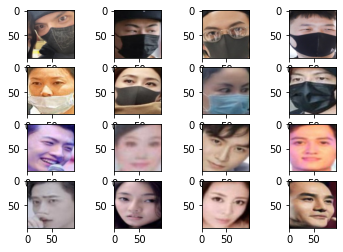

In [ ]:
print(len(base_mask))

for i in range(0, 8):
    plt.subplot(4, 4, i+1)
    plt.imshow(base_mask[i])
for i in range(0, 8):
    plt.subplot(4, 4, 8+i+1)
    plt.imshow(base_sans_mask[i])
plt.show()


In [ ]:
def convolution(in_, filter, kernel, strides):
  x = keras.layers.Conv2D(filter, kernel,strides=strides, padding='same', use_bias=False)(in_)
  x = keras.layers.BatchNormalization()(x)
  x = tf.nn.leaky_relu(x)
  return x

def discriminant():
    inputs = keras.Input(shape=(size, size, 3))
    x = convolution(inputs, 64, 5, strides=1)
    x = convolution(x, 64, 3, strides=2)
    x = convolution(x, 64*2, 3, strides=1)
    x = convolution(x, 64*2, 3, strides=2)
    x = convolution(x, 64*2*2, 3, strides=1)
    x = convolution(x, 64*2*2, 3, strides=2)
    x = convolution(x, 512, 3, strides=1)
    x = keras.layers.Conv2D(1, 3,strides=1, padding='same', use_bias=True)(x)

    return keras.Model(inputs=inputs, outputs=x)


def res(in_):
  x = convolution(in_, in_.shape[-1], 3, 1)
  x = keras.layers.Conv2D(in_.shape[-1], 3,strides=1, padding='same', use_bias=False)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.add([x, in_])
  return x

def generateur():
  inputs = keras.Input(shape=(size, size, 3))#96
  x = convolution(inputs,64,5,1)#96
  x = toto1 = convolution(x,64,3,1)#96
  x = convolution(x,64*2,3,2)#96/2
  x = toto2 = convolution(x,64*2,3,1)#96/2
  x = convolution(x,64*4,3,2)#96/4
  x = convolution(x,64*4,3,1)#96/4

  for _ in range(4):
    x = res(x)#96/4

  x = Conv2DTranspose(64*2, 5, strides=2,padding='same', use_bias=False )(x)#96/2
  x = keras.layers.BatchNormalization()(x)
  x = tf.nn.leaky_relu(x)

  x = keras.layers.Concatenate(3)([x, toto2])
  x = convolution(x,64*2,3,1)
  x = convolution(x,64*2,3,1)
  x = Conv2DTranspose(64, 5,strides=2, padding='same', use_bias=False )(x)#96
  x = keras.layers.BatchNormalization()(x)
  x = tf.nn.leaky_relu(x)
  x = keras.layers.Concatenate(3)([x, toto1])
  x = convolution(x,64,3,1)
  x = convolution(x,64,3,1)
  x = keras.layers.Conv2D(3,5,strides=1, padding='same', use_bias=True)(x)
  x = tf.nn.sigmoid(x)   
  return keras.Model(inputs=inputs, outputs=x)


In [ ]:
D_A  = discriminant()
D_B  = discriminant()

G_A2B = generateur()
G_B2A = generateur()

In [ ]:
tf.keras.utils.plot_model(
    D_A,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=96
)

In [ ]:
D_optimizer = keras.optimizers.Adam(learning_rate=0.001,beta_1=0.5 )
G_optimizer = keras.optimizers.Adam(learning_rate=0.001,beta_1=0.5 )

In [ ]:


def train_D(A, B, A2B, B2A):
    with tf.GradientTape() as t:
        A_d_logits   = D_A(  A, training=True)
        B2A_d_logits = D_A(B2A, training=True)#B2A fake 
        A_d_loss = tf.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(A_d_logits), A_d_logits)
        B2A_d_loss = tf.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(B2A_d_logits), B2A_d_logits)

        B_d_logits   = D_B(  B, training=True)
        A2B_d_logits = D_B(A2B, training=True)
        B_d_loss = tf.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(B_d_logits), B_d_logits)
        A2B_d_loss = tf.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(A2B_d_logits), A2B_d_logits)

        D_loss = (A_d_loss + B2A_d_loss) + (B_d_loss + A2B_d_loss) 

    D_grad = t.gradient(D_loss, D_A.trainable_variables + D_B.trainable_variables)
    D_optimizer.apply_gradients(zip(D_grad, D_A.trainable_variables + D_B.trainable_variables))



In [ ]:


def train_G(A, B):
    with tf.GradientTape() as t:
      A2B   = G_A2B(A, training=True)
      A2B2A = G_B2A(A2B, training=True)

      B2A = G_B2A(B, training=True)
      B2A2B = G_A2B(B2A, training=True)

      A2B_d_logits = D_B(A2B, training=True)
      B2A_d_logits = D_A(B2A, training=True)

      loss_cycle = tf.losses.MeanAbsoluteError()(A, A2B2A) +  tf.losses.MeanAbsoluteError()(B, B2A2B)
      dis_loss = tf.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(A2B_d_logits), A2B_d_logits) \
                 + tf.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(B2A_d_logits), B2A_d_logits) 

      """
      iden_loss = identity_loss_fn(A, A2B)+identity_loss_fn(B, B2A)#1er solution

      A2A = G_B2A(A, training=True)
      B2B = G_A2B(B, training=True)
      iden_loss = identity_loss_fn(A, A2A)+identity_loss_fn(B, B2B)#2eme solution
      """
      g_loss = 10 * loss_cycle + dis_loss
    G_grad = t.gradient(g_loss, G_A2B.trainable_variables + G_B2A.trainable_variables)
    G_optimizer.apply_gradients(zip(G_grad, G_A2B.trainable_variables + G_B2A.trainable_variables))
    return A2B, B2A

def train_step(A, B):
    A2B, B2A = train_G(A, B)
    train_D(A, B, A2B, B2A)

actuellement binarycrossentropy : y log(p) + (1-y) log(1-p)

Autres solutions : 


*  Least Squares Generative Adversarial Networks (https://arxiv.org/abs/1611.04076)
tf.losses.BinaryCrossentropy(from_logits=True) => tf.losses.meanSquaredError()

*   Wasserstein Loss (https://arxiv.org/abs/1701.07875)
Fake : tf.reduce_mean(A2B)
Reelle : -tf.reduce_mean(A)


In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, imgs,  batch_size=32,  shuffle=True, size=64):
        self.batch_size = batch_size
        self.size=size
        self.data=imgs
        self.indices = list(range(0, len(self.data)))
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        keys = [self.indices[k] for k in index]
        return self.__get_data(keys)

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def __get_data(self, keys):
        X = np.empty((self.batch_size, self.size, self.size, 3))
        for i, id in enumerate(keys): 
            X[i,] = self.data[id]
        return X


In [ ]:
database_mask  = DataGenerator(base_mask[int(1*batch_size):]     , size=size , batch_size=int(batch_size))
database_mask_val  = DataGenerator(base_mask[:int(1*batch_size)]     , size=size , batch_size=batch_size)

database_sans_mask = DataGenerator(base_sans_mask[int(1*batch_size):], size=size , batch_size=int(batch_size))
database_sans_mask_val = DataGenerator(base_sans_mask[:int(1*batch_size)], size=size , batch_size=batch_size)

print ("Tailla batch database_mask : ", database_mask.__len__())
print ("Tailla batch base_sans_mask : ", database_sans_mask.__len__())
print ("Tailla batch database_mask val : ", database_mask_val.__len__())
print ("Tailla batch base_sans_mask val: ", database_sans_mask_val.__len__())



Tailla batch database_mask :  544
Tailla batch base_sans_mask :  2499
Tailla batch database_mask val :  1
Tailla batch base_sans_mask val:  1


In [1]:


At = database_mask_val.__getitem__(0)
Bt = database_sans_mask_val.__getitem__(0)

ib = 0
ia = 0 
for ite in range(20000):
  B = database_sans_mask.__getitem__(ib)
  A = database_mask.__getitem__(ia)
  if ite%10==0: #Generateur ++ 
    ib = (ib+1)%database_sans_mask.__len__()
    ia = (ia+1)%database_mask.__len__()

    if(ib==0):
      database_sans_mask.on_epoch_end()
    if(ia==0):
      database_mask.on_epoch_end()

  train_step(A, B)
  if ite%100==0:
    A2B = G_A2B(At, training=False)
    B2A = G_B2A(Bt, training=False)

    plt.figure(dpi=100, figsize=[12,8])
    for i in range(4):
        plt.subplot(4,4,1+i*4)
        plt.imshow(At[i])
        plt.subplot(4,4,2+i*4)
        plt.imshow(A2B[i])
        plt.subplot(4,4,3+i*4)
        plt.imshow(Bt[i])
        plt.subplot(4,4,4+i*4)
        plt.imshow(B2A[i])
    plt.show()


NameError: ignored